# Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import inspect  # inspect.signature()
import json
import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')

%matplotlib inline
viz.notebook_full_width()

In [2]:
dataset_name = constants.MASS_SS_NAME
fs = 200
which_expert = 1
task_mode = constants.N2_RECORD
seed_id_list = [i for i in range(4)]
set_list = [constants.VAL_SUBSET, constants.TRAIN_SUBSET]

# Specify what to load
comparison_runs_list = [
    ('20191227_bsf_10runs_e1_n2_train_mass_ss/v11', 'RED-Time'),
    ('20191227_bsf_10runs_e1_n2_train_mass_kc/v11', 'RED-Time')]
comparison_runs_list = [
    (t_folder, t_label) for (t_folder, t_label) in comparison_runs_list if dataset_name in t_folder
]
ckpt_folder_list = [t_folder for (t_folder, t_label) in comparison_runs_list]
ckpt_folder_dict = {t_label: t_folder for (t_folder, t_label) in comparison_runs_list}
ckpt_label_dict = {t_folder: t_label for (t_folder, t_label) in comparison_runs_list}

# Load data
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: fs})
ids_dict = {
    constants.ALL_TRAIN_SUBSET: dataset.train_ids,
    constants.TEST_SUBSET: dataset.test_ids}
ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))
predictions_dict = {}
for ckpt_folder in ckpt_folder_list:
    predictions_dict[ckpt_folder] = reader.read_prediction_with_seeds(
        ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset, verbose=False)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


# Single example

In [68]:
def compute_border_weight(label_mask, max_val, std_samples):
    last_sample = label_mask.size - 1
    edges = [-0.5, last_sample+0.5]
    intervals = utils.seq2stamp(label_mask).astype(np.float32)
    intervals = intervals + np.array([[-0.5, 0.5]])
    borders = intervals.flatten()
    borders = [b for b in borders if b not in edges]
    borders = np.array(borders)
    idx_array = np.arange(last_sample + 1)
    distances_matrix = np.abs(idx_array.reshape(-1, 1) - borders.reshape(1, -1)) - 0.5
    distances = distances_matrix.min(axis=1)
    weights = max_val * np.exp( - distances**2 / (2 * std_samples ** 2))
    return weights 

Close annotations idx: [43]


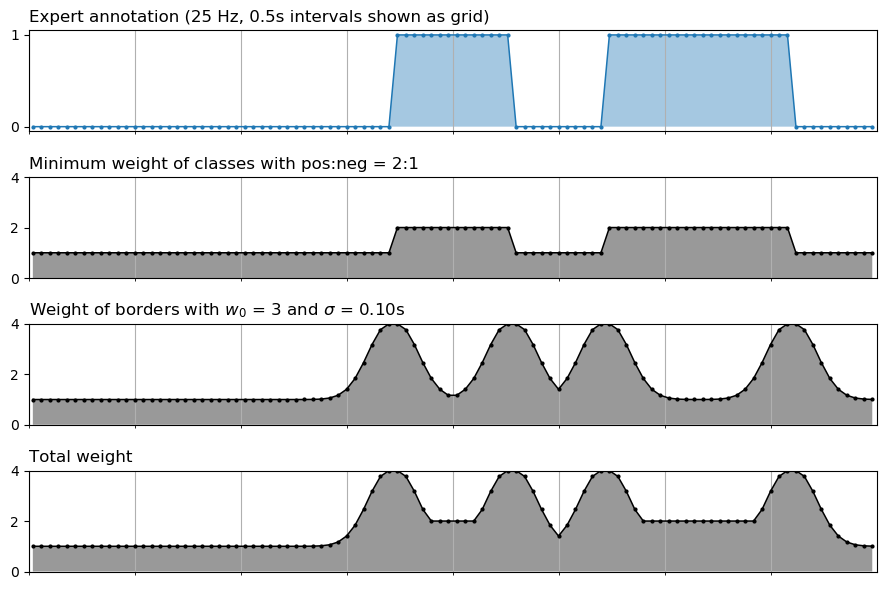

In [212]:
# Segment
subject_id = 2
which_idx = 43
window = 4
time_stride = 8
annots = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=task_mode)


gaps = annots[1:, 0] - annots[:-1, 1]
print('Close annotations idx:', np.where(gaps<=100)[0])

pages = dataset.get_subject_pages(subject_id=1, pages_subset='wn')
last_sample = (pages[-1] + 1) * dataset.page_size
binary_mask = utils.stamp2seq(annots, 0, last_sample-1, allow_early_end=True)
which_idx = min(which_idx, annots.shape[0] - 1)
central_sample = int(annots[which_idx, :].mean())
side_samples = int((fs * window) // 2)
start_sample = central_sample - side_samples
end_sample = start_sample + 2*side_samples
binary_segment = binary_mask[start_sample:end_sample]
binary_segment = binary_segment.reshape((int(binary_segment.size / time_stride), time_stride)).mean(axis=1) + 1e-3
binary_segment = np.round(binary_segment).astype(np.int32)
time_segment = np.arange(start_sample, end_sample) / fs
time_segment = time_segment[time_stride//2::time_stride]

# Weights of borders
std_time = 0.1
std = fs * std_time / 8
w_0 = 3
weights_borders = 1 + compute_border_weight(binary_segment, w_0, std)
# Weights of classes
weight_neg = 1
weight_pos = 2
weights_classes = np.array([weight_neg, weight_pos]).reshape(1, 2)
labels_onehot = np.stack([1 - binary_segment, binary_segment], axis=1)
weights_classes = np.sum(labels_onehot * weights_classes, axis=1)
# Combination
# weights = weights_borders + weights_classes
weights = np.stack([weights_borders, weights_classes], axis=1).max(axis=1)

fig, ax = plt.subplots(4, 1, figsize=(9, 6), dpi=100)
# Annotation
ax[0].set_title('Expert annotation (25 Hz, 0.5s intervals shown as grid)', loc='left')
ax[0].plot(time_segment, binary_segment, linewidth=1.1, marker='o', markersize=2)
ax[0].fill_between(time_segment, 0, binary_segment, alpha=0.4)
ax[0].set_ylim([-0.05, 1.05])
ax[0].set_yticks([0, 1])

# Weights
ax[1].set_title('Minimum weight of classes with pos:neg = %d:%d' % (weight_pos, weight_neg), loc='left')
ax[1].plot(time_segment, weights_classes, linewidth=1.1, marker='o', markersize=2, color='k')
ax[1].fill_between(time_segment, 0, weights_classes, alpha=0.4, facecolor='k')
ax[1].set_ylim([0, w_0+1])

ax[2].set_title(
    'Weight of borders with $w_0$ = %d and $\sigma$ = %1.2fs' % (w_0, std_time), 
    loc='left')
ax[2].plot(time_segment, weights_borders, linewidth=1.1, marker='o', markersize=2, color='k')
ax[2].fill_between(time_segment, 0, weights_borders, alpha=0.4, facecolor='k')
ax[2].set_ylim([0, w_0+1])

ax[3].set_title('Total weight', loc='left')
ax[3].plot(time_segment, weights, linewidth=1.1, marker='o', markersize=2, color='k')
ax[3].fill_between(time_segment, 0, weights, alpha=0.4, facecolor='k')
ax[3].set_ylim([0, w_0+1])

# Common
for s_ax in ax:
    s_ax.set_xlim([start_sample/fs, end_sample/fs])
    s_ax.set_xticks(np.arange(start_sample/fs, end_sample/fs, 0.5), minor=True)
    s_ax.grid(which='minor')
    s_ax.set_xticks([])
    

plt.tight_layout()
if True:
    plt.savefig(
        "w_borders_pos_%d_neg_%d_w0_%d_std_%1.2f.png" % (weight_pos, weight_neg, w_0, std_time), 
        dpi=200, bbox_inches="tight", pad_inches=0.01)
plt.show()

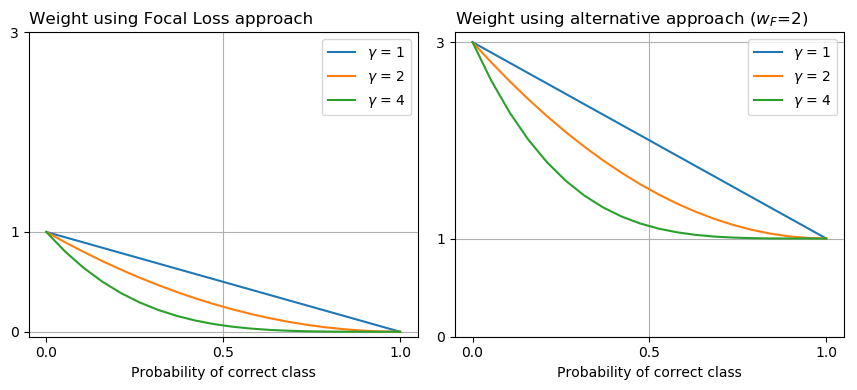

In [213]:
# Modified focal loss
# Instead of discounting easy ones to zero, increase weight of harder ones.
w_false = 2
powers_list = [1, 2, 4]
p = np.linspace(0, 1, num=20, endpoint=True)

fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=100)
axes[0].set_title('Weight using Focal Loss approach', loc='left')
for gamma in powers_list:
    axes[0].plot(p, (1-p) ** gamma, label='$\gamma$ = %d' % gamma)
axes[1].set_title('Weight using alternative approach ($w_F$=%d)' % w_false, loc='left')
for gamma in powers_list:
    axes[1].plot(p, 1+ w_false*(1-p) ** gamma, label='$\gamma$ = %d' % gamma)
for ax in axes:
    ax.legend()
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticks([0.5], minor=True)
    ax.grid(which='minor')
    ax.set_xlabel('Probability of correct class')
    ax.set_yticks([0, 1, 1+w_false])
    ax.set_yticks([0, 1, 1+w_false], minor=True)
plt.tight_layout()
if True:
    plt.savefig(
        "w_falses_wf_%d.png" % (w_false), 
        dpi=200, bbox_inches="tight", pad_inches=0.01)
plt.show()